# XGBoost Parameter Tuning for Otto Dataset

我们以Kaggle 2015年举办的Otto Group Product Classification Challenge竞赛数据为例，进行XGBoost参数调优探索。

竞赛官网：https://www.kaggle.com/c/otto-group-product-classification-challenge/data

首先 import 必要的模块

In [1]:
import sys
sys.path.append('/mnt/wc/xgboost/python-package')

In [2]:
from xgboost import XGBClassifier
import xgboost as xgb

import pandas as pd 
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import log_loss

from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

## 读取数据

In [3]:
# path to where the data lies
#dpath = '/Users/qing/desktop/XGBoost/data/'
dpath = './data/'
train = pd.read_csv(dpath +"Otto_train.csv")
#train.head()

## Variable Identification

选择该数据集是因为的数据特征单一，我们可以在特征工程方面少做些工作，集中精力放在参数调优上

## Target 分布，看看各类样本分布是否均衡

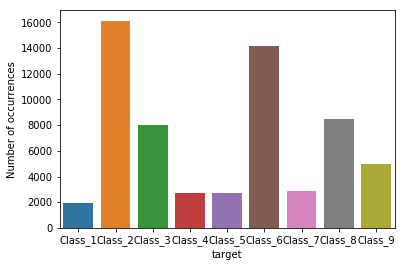

In [4]:
sns.countplot(train.target);
pyplot.xlabel('target');
pyplot.ylabel('Number of occurrences');

每类样本分布不是很均匀，所以交叉验证时也考虑各类样本按比例抽取

In [5]:
# drop ids and get labels
y_train = train['target']
y_train = y_train.map(lambda s: s[6:])
y_train = y_train.map(lambda s: int(s)-1)

train = train.drop(["id", "target"], axis=1)
X_train = np.array(train)

各类样本不均衡，交叉验证是采用StratifiedKFold，在每折采样时各类样本按比例采样

In [6]:
# prepare cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

再次调整弱分类器数目

In [8]:
def modelfit(alg, X_train, y_train, useTrainCV=True, cv_folds=None, early_stopping_rounds=100):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgb_param['num_class'] = 9
        
        xgtrain = xgb.DMatrix(X_train, label = y_train)
        
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], folds =cv_folds,
                         metrics='mlogloss', early_stopping_rounds=early_stopping_rounds)
        
        n_estimators = cvresult.shape[0]
        alg.set_params(n_estimators = n_estimators)
        
        print (cvresult)
        #result = pd.DataFrame(cvresult)   #cv缺省返回结果为DataFrame
        #result.to_csv('my_preds.csv', index_label = 'n_estimators')
        cvresult.to_csv('my_preds4_2_3_699.csv', index_label = 'n_estimators')
        
        # plot
        test_means = cvresult['test-mlogloss-mean']
        test_stds = cvresult['test-mlogloss-std'] 
        
        train_means = cvresult['train-mlogloss-mean']
        train_stds = cvresult['train-mlogloss-std'] 

        x_axis = range(0, n_estimators)
        pyplot.errorbar(x_axis, test_means, yerr=test_stds ,label='Test')
        pyplot.errorbar(x_axis, train_means, yerr=train_stds ,label='Train')
        pyplot.title("XGBoost n_estimators vs Log Loss")
        pyplot.xlabel( 'n_estimators' )
        pyplot.ylabel( 'Log Loss' )
        pyplot.savefig( 'n_estimators4_2_3_699.png' )
    
    #Fit the algorithm on the data
    alg.fit(X_train, y_train, eval_metric='mlogloss')
        
    #Predict training set:
    train_predprob = alg.predict_proba(X_train)
    logloss = log_loss(y_train, train_predprob)

        
    #Print model report:
    print ("logloss of train :" )
    print(logloss)

     test-mlogloss-mean  test-mlogloss-std  train-mlogloss-mean  \
0              1.961627           0.000517             1.955248   
1              1.795796           0.003058             1.783224   
2              1.665884           0.004086             1.647505   
3              1.558645           0.002543             1.534984   
4              1.465400           0.001869             1.437175   
5              1.387757           0.003655             1.354824   
6              1.314721           0.004154             1.277752   
7              1.251777           0.003837             1.211168   
8              1.195794           0.005206             1.151364   
9              1.144679           0.004419             1.096901   
10             1.099433           0.004261             1.048852   
11             1.058590           0.004060             1.005104   
12             1.021257           0.004488             0.964658   
13             0.987000           0.004927             0.92756

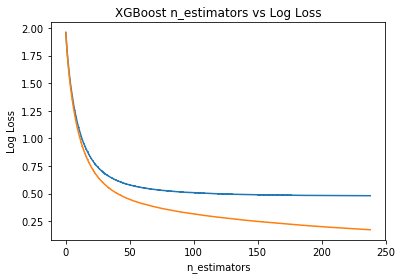

In [9]:
#调整max_depth和min_child_weight之后再次调整n_estimators(6,4)
xgb2_3 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=699,  #数值大没关系，cv会自动返回合适的n_estimators
        max_depth=9,
        min_child_weight=0.5,
        gamma=0,
        subsample=0.3,
        colsample_bytree=0.8,
        colsample_bylevel=0.7,
        objective= 'multi:softprob',
        seed=3,
        tree_method='gpu_hist',
        predictor='gpu_predictor',
        n_jobs= -1)

modelfit(xgb2_3, X_train, y_train, cv_folds = kfold)
#from sklearn.model_selection import cross_val_score
#results = cross_val_score(xgb2_3, X_train, y_train, metrics='mlogloss', cv=kfold)
#print results
#print("CV logloss: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

/mnt/wc/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


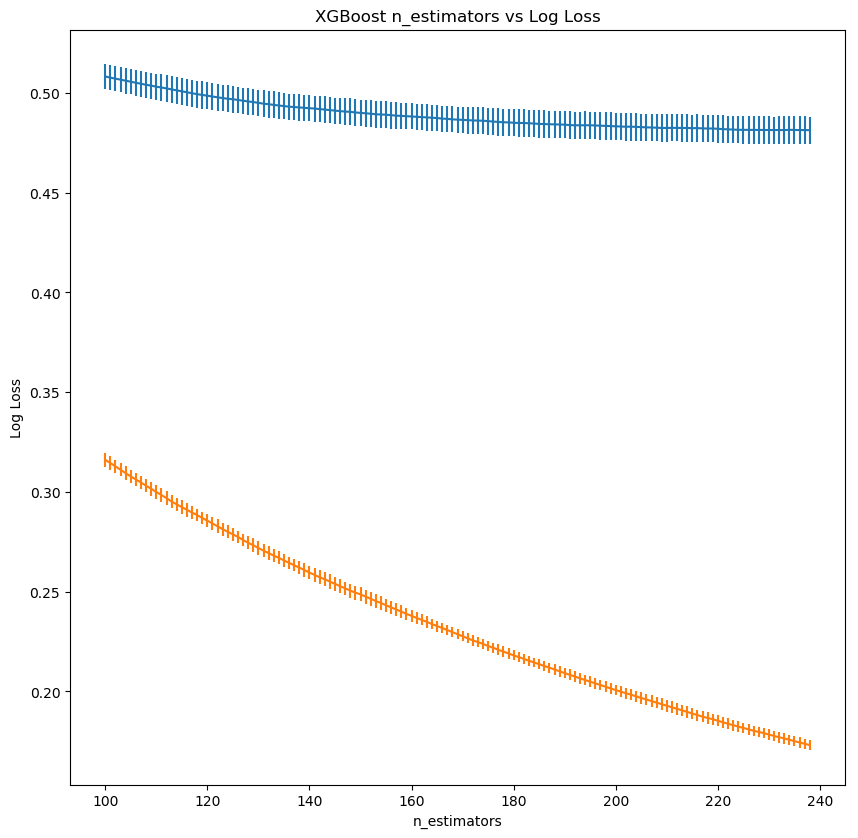

In [10]:
cvresult = pd.DataFrame.from_csv('my_preds4_2_3_699.csv')

cvresult = cvresult.iloc[100:]
# plot
test_means = cvresult['test-mlogloss-mean']
test_stds = cvresult['test-mlogloss-std'] 
        
train_means = cvresult['train-mlogloss-mean']
train_stds = cvresult['train-mlogloss-std'] 

x_axis = range(100,cvresult.shape[0]+100)
        
fig = pyplot.figure(figsize=(10, 10), dpi=100)
pyplot.errorbar(x_axis, test_means, yerr=test_stds ,label='Test')
pyplot.errorbar(x_axis, train_means, yerr=train_stds ,label='Train')
pyplot.title("XGBoost n_estimators vs Log Loss")
pyplot.xlabel( 'n_estimators' )
pyplot.ylabel( 'Log Loss' )
pyplot.savefig( 'n_estimators_detail4_2_3_699.png' )

pyplot.show()

In [11]:
xgb2_3.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 0.7,
 'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 9,
 'min_child_weight': 0.5,
 'missing': None,
 'n_estimators': 239,
 'n_jobs': -1,
 'nthread': None,
 'objective': 'multi:softprob',
 'predictor': 'gpu_predictor',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 3,
 'silent': True,
 'subsample': 0.3,
 'tree_method': 'gpu_hist'}